## Bare pretrained Resnet backbone evaluation

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
efficient_net_dir = "../pretrained_backbone/ckpt_efficientnet_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

## Datasets

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [4]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [6]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)
    
    def forward(self, X):
        return self.model(X)
        
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

## No fine-tuning: Evaluation directly on ODIR test set

In [7]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    for X, _ in tqdm(loader):
        output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
        preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [8]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  5.71it/s]

              precision    recall  f1-score   support

           D       0.72      0.29      0.42       140
           G       0.44      0.78      0.56        49
           A       0.31      0.68      0.42        22

   micro avg       0.49      0.45      0.47       211
   macro avg       0.49      0.58      0.47       211
weighted avg       0.61      0.45      0.45       211
 samples avg       0.49      0.44      0.37       211



### Offsite

![](efficientnet_no_tuning.png)

In [9]:
eval_model(model, onsite_test, "efficient_submission_notune.csv")

100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


## Frozen backbone, fine-tuning classifier only

In [10]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.classifier[1].parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [11]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            
        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()
    
    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

Validation: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch: 0 - Train Loss: 1.098288 - Val Loss: 0.711097 - Val Accuracy: 0.334821 - Val F1 (avg. samples): 0.446429
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch: 1 - Train Loss: 0.475640 - Val Loss: 0.535541 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.648810
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch: 2 - Train Loss: 0.422294 - Val Loss: 0.496456 - Val Accuracy: 0.584821 - Val F1 (avg. samples): 0.686012
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch: 3 - Train Loss: 0.411115 - Val Loss: 0.467198 - Val Accuracy: 0.575893 - Val F1 (avg. samples): 0.694940
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch: 4 - Train Loss: 0.398196 - Val Loss: 0.449025 - Val Accuracy: 0.589286 - Val F1 (avg. samples): 0.690476
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch: 5 - Train Loss: 0.379047 - Val Loss: 0.460154 - Val Accuracy: 0.589286 - Val F1 (avg. samples): 0.708333


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch: 6 - Train Loss: 0.368807 - Val Loss: 0.440268 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.705357
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch: 7 - Train Loss: 0.364415 - Val Loss: 0.428351 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.703869
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch: 8 - Train Loss: 0.363813 - Val Loss: 0.423052 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.703869
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch: 9 - Train Loss: 0.364067 - Val Loss: 0.432809 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.717262


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


Epoch: 10 - Train Loss: 0.348345 - Val Loss: 0.427473 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.714286


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


Epoch: 11 - Train Loss: 0.350449 - Val Loss: 0.428900 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.714286


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]


Epoch: 12 - Train Loss: 0.349771 - Val Loss: 0.431653 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.693452


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch: 13 - Train Loss: 0.342569 - Val Loss: 0.414324 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.706845
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch: 14 - Train Loss: 0.343761 - Val Loss: 0.418153 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.706845


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]


Epoch: 15 - Train Loss: 0.321964 - Val Loss: 0.425611 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.708333


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch: 16 - Train Loss: 0.340905 - Val Loss: 0.411583 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.706845
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch: 17 - Train Loss: 0.327752 - Val Loss: 0.408059 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.706845
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch: 18 - Train Loss: 0.330958 - Val Loss: 0.424138 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.700893


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch: 19 - Train Loss: 0.329396 - Val Loss: 0.405831 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.703869
Model improved! Saving if checkpoint_name is set.


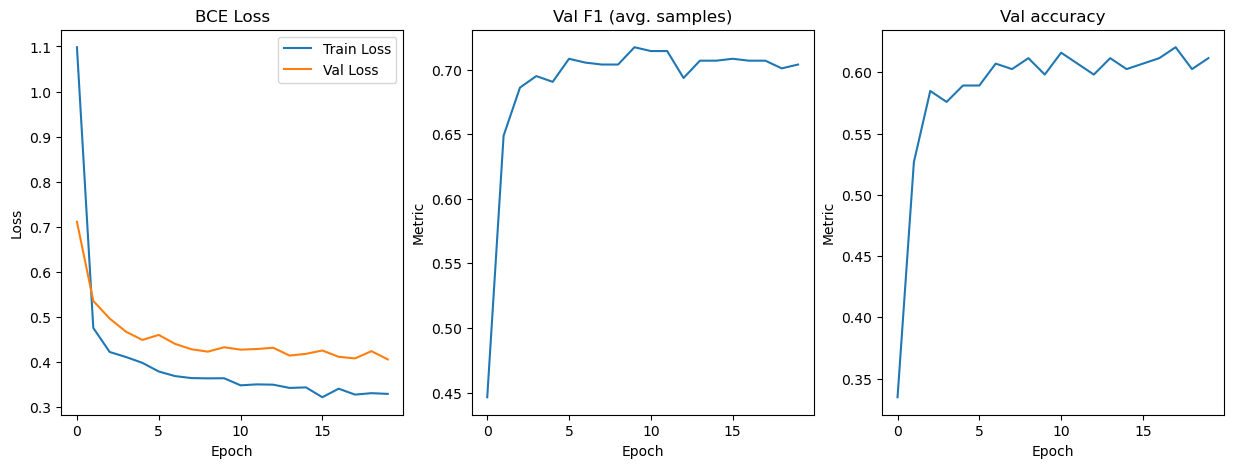

In [12]:
optimizer = torch.optim.AdamW(model.model.classifier[1].parameters(), lr = 1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="efficient_tuned_classifer.pt")

### Offsite test

In [13]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  5.52it/s]

              precision    recall  f1-score   support

           D       0.84      0.87      0.85       140
           G       0.78      0.51      0.62        49
           A       0.67      0.45      0.54        22

   micro avg       0.81      0.74      0.78       211
   macro avg       0.76      0.61      0.67       211
weighted avg       0.81      0.74      0.77       211
 samples avg       0.82      0.76      0.76       211



### Onsite test
![](efficientnet_classifier_tuning.png)

In [14]:
eval_model(model, onsite_test, "efficient_net_submission_classifier_tune.csv")

100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


## Full fine-tuning

Only 3 epochs no more, usually overfits after epoch 1, lr = 1e-4 seem to be most optimal, no weight decay

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch: 0 - Train Loss: 0.326039 - Val Loss: 0.393035 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.711310
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch: 1 - Train Loss: 0.275513 - Val Loss: 0.387432 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.735119
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch: 2 - Train Loss: 0.262720 - Val Loss: 0.384584 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.750000
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch: 3 - Train Loss: 0.235449 - Val Loss: 0.383024 - Val Accuracy: 0.656250 - Val F1 (avg. samples): 0.775298
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch: 4 - Train Loss: 0.217471 - Val Loss: 0.382998 - Val Accuracy: 0.656250 - Val F1 (avg. samples): 0.775298
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch: 5 - Train Loss: 0.201526 - Val Loss: 0.391743 - Val Accuracy: 0.651786 - Val F1 (avg. samples): 0.776786


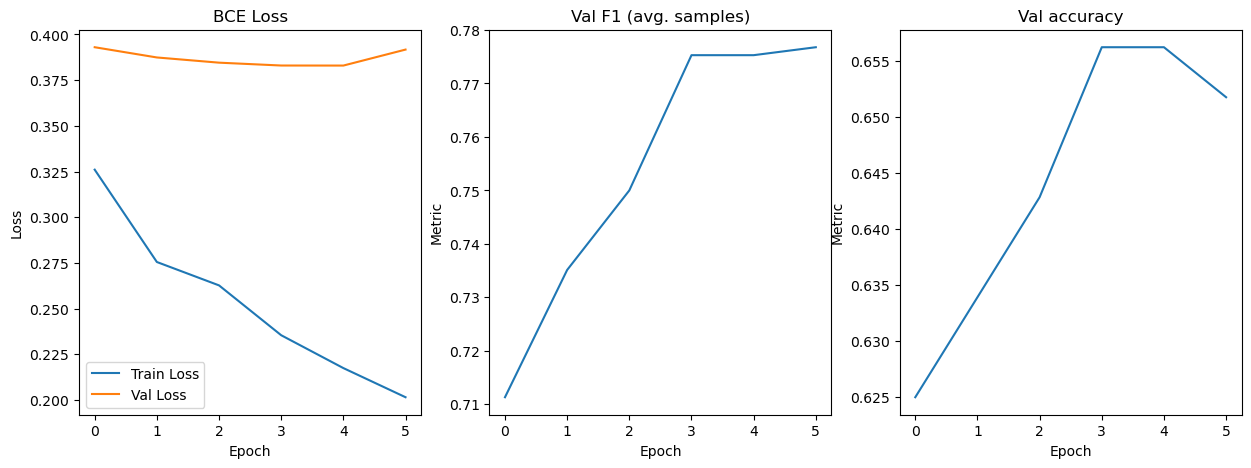

In [15]:
for layer in model.parameters():
    layer.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=6, stepLR=scheduler, checkpoint_name="efficient.pt")

### Offsite

In [16]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.89it/s]

              precision    recall  f1-score   support

           D       0.84      0.88      0.86       140
           G       0.81      0.59      0.68        49
           A       0.68      0.59      0.63        22

   micro avg       0.82      0.78      0.80       211
   macro avg       0.78      0.69      0.73       211
weighted avg       0.82      0.78      0.80       211
 samples avg       0.84      0.80      0.80       211



### Onsite test
![](efficientnet_classifier_full.png)

In [17]:
eval_model(model, onsite_test, "efficient_net_submission_full.csv")

100%|██████████| 8/8 [00:01<00:00,  5.43it/s]
